In [178]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import requests
import json
import itertools
from pandas.io.json import json_normalize
import community
from networkx.algorithms.community import k_clique_communities

## INICIO DA COLETA DE DADOS

In [3]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    return categories_list[0]['name']

In [4]:
CLIENT_ID = '55LWIFZLZNZPSTAZZQKJXBD11BSBCUZTZPIXWVV4RFZJP1HS' # your Foursquare ID
CLIENT_SECRET = 'RPCOWGHQY5YNQUCHQUTC5VLKEYFGZN15FSIYTK5GNXNZ301E' # your Foursquare Secret
VERSION = '20180604'

In [115]:
latitude_nyork = 48.8534100
longitude_nyork = 2.3488000
radius = 5000
LIMIT = 10000

In [117]:
QUERY = 'café'
url = 'https://api.foursquare.com/v2/venues/search?intent=browse&query={}&client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
    QUERY, CLIENT_ID, CLIENT_SECRET, latitude_nyork, longitude_nyork, VERSION, radius, LIMIT)
results = requests.get(url).json()
locais = results['response']['venues'] 
locais_proximos = json_normalize(locais)
filtered_columns = ['id', 'name', 'categories', 'location.lat', 'location.lng']
locais_proximos = locais_proximos.loc[:, filtered_columns]
locais_proximos['categories'] = locais_proximos.apply(get_category_type, axis=1)
locais_proximos.columns = [col.split(".")[-1] for col in locais_proximos.columns]
locais_proximos.head(10)

,id,name,categories,lat,lng
0,4adcda04f964a520323221e3,Café de Flore,Café,48.854106,2.332634
1,4adcda04f964a520503221e3,Café Marly,Café,48.861596,2.335676
2,562a40c3498e425bd63baa85,Shakespeare & Company Café,Coffee Shop,48.852492,2.347197
3,57220324498eaeb1b97f405b,Café Le Buci,Café,48.853795,2.338285
4,57222bc7498ea8de6c6d8c24,Café Belleville,Café,48.861210,2.346806
5,4adcda06f964a520cc3221e3,Café RUC,Coffee Shop,48.863083,2.335545
6,4bbcc5db8ec3d13ac3351b28,Café du Châtelet,Café,48.858547,2.347379
7,4b026607f964a520894822e3,Café Charlot,Bistro,48.862940,2.362580
8,4adcda08f964a520803321e3,Café Rive Droite,Karaoke Bar,48.860847,2.348837
9,4bb5dd68941ad13a6c941ee3,Café Voulez-Vous,Gay Bar,48.858559,2.353403


In [120]:
checkins_locais = pd.DataFrame()
for i,local in locais_proximos.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}/likes?client_id={}&client_secret={}&v={}&limit={}'.format(
    local['id'], CLIENT_ID, CLIENT_SECRET, VERSION, 10000)
    results = requests.get(url).json()
    if (results['response']['likes']['count'] > 0) & ('items' in results['response']['likes']):
        results_2 = results['response']['likes']['items']
        checkins = json_normalize(results_2)[['id', 'firstName', 'gender']]
        checkins['avenue_id'] = local['id']
        checkins['avenue_name'] = local['name']
        checkins['avenue_categories'] = local['categories']
        checkins['avenue_lat'] = local['lat']
        checkins['avenue_lng'] = local['lng']
        if checkins_locais.empty:
            checkins_locais = checkins
        else:
            checkins_locais = pd.concat([checkins_locais, checkins], ignore_index=True)

In [121]:
checkins_locais.to_csv('victor_likes_locais.csv', index=False)

In [122]:
checkins_locais.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
8412,71821165,Bouche à Bouches,none,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518
8413,46973275,Ludovic,male,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518
8414,2277322,Caro,female,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518
8415,38298062,Linkrod,male,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518
8416,10631218,Copper,female,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518


In [123]:
likes_value_counts = checkins_locais['avenue_id'].value_counts()
likes_value_value = likes_value_counts.index

In [124]:
likes = list(likes_value_value)

In [125]:
likes_completo = checkins_locais[checkins_locais['avenue_id'].isin(likes)]

In [126]:
likes_completo.tail()

,id,firstName,gender,avenue_id,avenue_name,avenue_categories,avenue_lat,avenue_lng
8412,71821165,Bouche à Bouches,none,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518
8413,46973275,Ludovic,male,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518
8414,2277322,Caro,female,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518
8415,38298062,Linkrod,male,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518
8416,10631218,Copper,female,4bc8c6228b7c9c7401e338cf,Café de l'Époque,French Restaurant,48.863048,2.339518


In [127]:
vc = likes_completo['id'].value_counts()

In [147]:
filter = vc[vc >= 2].index.tolist()

In [148]:
usuarios_unicos = likes_completo[likes_completo['id'].isin(filter)]['id'].drop_duplicates()

In [149]:
usuarios_unicos = usuarios_unicos.tolist()

In [150]:
len(usuarios_unicos)

754

In [151]:
grafo = nx.Graph()
for usuarios in usuarios_unicos:
    grafo.add_node(str(usuarios), 
           nome=likes_completo[likes_completo['id']==usuarios]['firstName'].values[0],
           genero=likes_completo[likes_completo['id']==usuarios]['gender'].values[0])
for u in usuarios_unicos:
    # locais que esta pessoa deu checkin...
    locais = list(likes_completo[likes_completo['id']==u]['avenue_id'].values)
    # outras pessoas que deram checkin nestes locais...
    outros_usuarios = list(likes_completo[
        (likes_completo['avenue_id'].isin(locais)) &
        (likes_completo['id'].isin(usuarios_unicos)) &
        (likes_completo['id'] != u)]['id'].values)
    for outro in outros_usuarios:
        if grafo.has_edge(str(u), str(outro)):
            grafo[str(u)][str(outro)]['weight'] = grafo[str(u)][str(outro)]['weight'] + 1
        else:
            grafo.add_edge(str(u), str(outro), weight=1)

In [152]:
pos = nx.spring_layout(grafo)

(-1.0840445971582429,
 0.7421736264840865,
 -0.7849823910194622,
 0.6282227577456747)

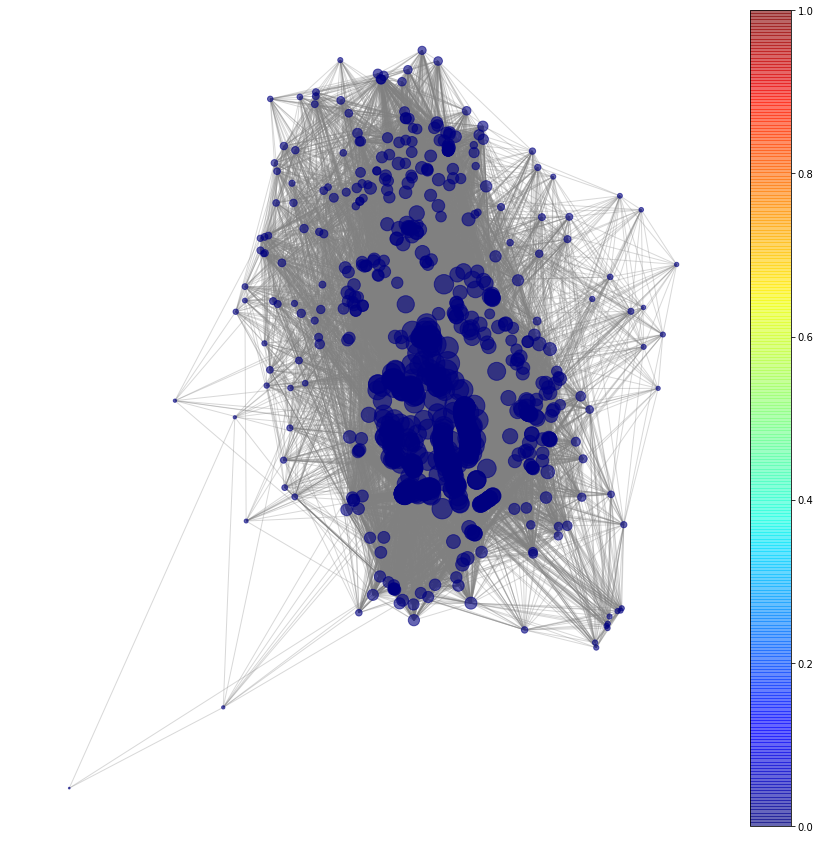

In [153]:
node_color = [0.0 for node in grafo.nodes()]
node_size = [grafo.degree(node) for node in grafo.nodes()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=1.0,
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

(-1.0840445971582429,
 0.7421736264840865,
 -0.7849823910194622,
 0.6282227577456747)

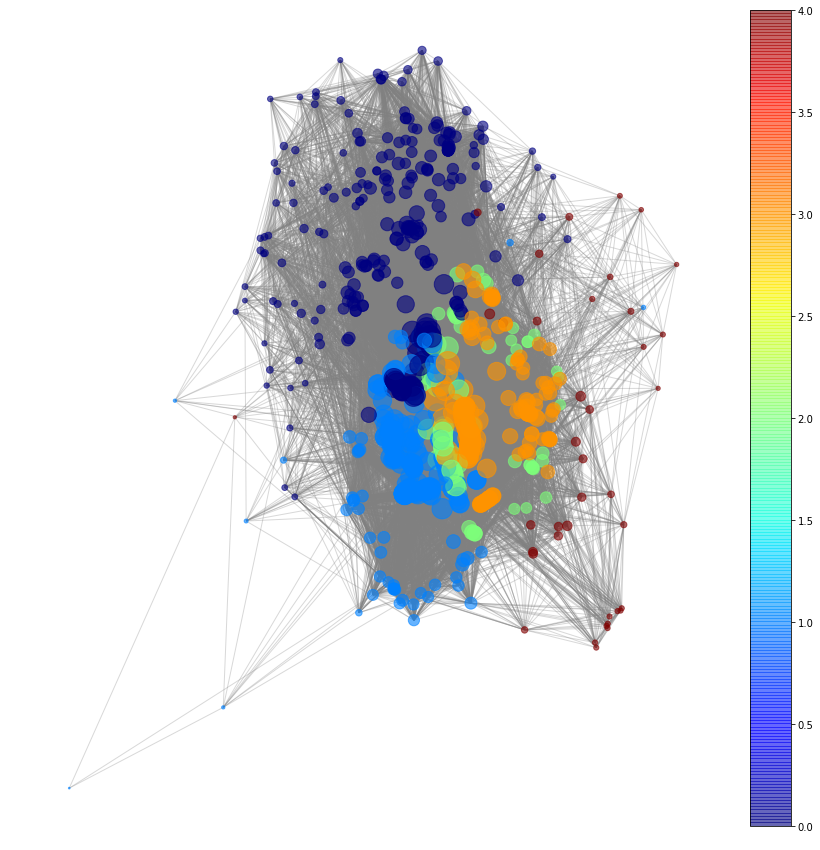

In [154]:
partition = community.best_partition(grafo, weight='weight')
node_color = [partition.get(node) for node in grafo.nodes()]
node_size = [grafo.degree(node) for node in grafo.nodes()]
plt.figure(figsize=(15,15))
ed = nx.draw_networkx_edges(grafo, pos=pos, alpha=0.3, edge_color='gray')
no = nx.draw_networkx_nodes(grafo, pos=pos, alpha=0.6, with_labels=False, node_color=node_color, 
                            cmap=cm.jet, vmin=0.0, vmax=max(partition.values()),
                            node_size=node_size)
plt.colorbar(no)
plt.axis('off')

In [213]:
likes_completo['cluster'] = likes_completo['id'].apply(lambda x: partition[x] if x in list(partition.keys()) else None)   

In [220]:
likes_com_cluster = likes_completo[~likes_completo['cluster'].isnull()]

In [228]:
likes_com_cluster[likes_com_cluster['cluster'] == 0]['avenue_name'].value_counts()[:5]

Café Charlot           98
Café de l'Industrie    87
Café des Anges         54
Café de Flore          51
Café Père & Fils       26
Name: avenue_name, dtype: int64

In [229]:
likes_com_cluster[likes_com_cluster['cluster'] == 1]['avenue_name'].value_counts()[:5]

Café de Flore           159
Hard Rock Cafe Paris     87
Café RUC                 19
Café Louise              17
Café Palais Royal         9
Name: avenue_name, dtype: int64

In [230]:
likes_com_cluster[likes_com_cluster['cluster'] == 2]['avenue_name'].value_counts()[:5]

Café Marly              86
Café de Flore           48
Café RUC                12
Café Charlot            10
Hard Rock Cafe Paris     6
Name: avenue_name, dtype: int64

In [231]:
likes_com_cluster[likes_com_cluster['cluster'] == 3]['avenue_name'].value_counts()[:5]

Café de la Paix         164
Café de Flore            71
Hard Rock Cafe Paris     25
Café Marly               23
Café RUC                 15
Name: avenue_name, dtype: int64

In [232]:
likes_com_cluster[likes_com_cluster['cluster'] == 4]['avenue_name'].value_counts()[:5]

Café Richelieu – Angelina    25
Café RUC                     12
Café Rive Droite             11
Café du Châtelet              7
Café Arena                    3
Name: avenue_name, dtype: int64